# Rice Leaf classification -- simple CNN

In this notebook, we used a simple non-pretrained CNN model to tackle the classifcaiton task. When designing the model, we mainly had model simplicity in mind. The goal was to see if a simpler model could achieve relatively satisfactory results compared to more complex pretrained model while maintaining low computational complexity.

This package is used to visualize the model architecture of the model.

In [ ]:
! pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=3cb491801d9cdfd6eb622ff721384ad52a8f52c95b972ad9dff05b5936ccc607
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


In [ ]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
from PIL import Image
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torchsummary import summary
from torchviz import make_dot
from graphviz import render
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import os

When input_data = 'original', the original images will be used to train the model. When input_data = 'preprocessed', the model will train on the preprocessed (using method specified in report Chapter 2) dataset.

In [ ]:
# input_data can be 'original' or 'preprocessed'
input_data = 'preprocessed'

Below are paths of the 2 datasets, the csv files, and the model. Change the paths before running the other cells.

In [ ]:
if input_data == 'original':
  DIR_DATA = "data/original/"
else:
  DIR_DATA = "data/preprocessed/"
DIR_CSV = "data/"
DIR_MODEL = "model/"

Print out the number of images in each class folder.

In [ ]:
classes = os.listdir(DIR_DATA)
print("Total Classes: ",len(classes))

train_count = 0
valid_count = 0

for label in classes:
  class_folder_path = os.path.join(DIR_DATA, label)
  if os.path.isdir(class_folder_path):
      num_images = len([f for f in os.listdir(class_folder_path) if os.path.isfile(os.path.join(class_folder_path, f))])
      print(f"Class {label}: {num_images} images")

Total Classes:  4
Class Hispa: 565 images
Class Healthy: 1488 images
Class BrownSpot: 523 images
Class LeafBlast: 779 images


# Data Normalization

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Class to read in images and the corresponding labels.

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, csv_file, transform=None):
    self.data_frame = pd.read_csv(csv_file)
    self.transform = transform
    self.classes = sorted(self.data_frame['class'].unique())
    self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path = self.data_frame.loc[idx, "path"]
    image = Image.open(img_path).convert("RGB")
        
    label = self.data_frame.loc[idx, "class"]
    label_idx = self.class_to_idx[label]
    if self.transform:
      image = self.transform(image)

    return image, label_idx

In [ ]:
if input_data == 'original':
  train_data = CustomImageDataset(csv_file=DIR_CSV+"train_data_original.csv", transform=transform)
  val_data = CustomImageDataset(csv_file=DIR_CSV+"val_data_original.csv", transform=transform)
  test_data = CustomImageDataset(csv_file=DIR_CSV+"test_data_original.csv", transform=transform)
else:
  train_data = CustomImageDataset(csv_file=DIR_CSV+"train_data_preprocessed.csv", transform=transform)
  val_data = CustomImageDataset(csv_file=DIR_CSV+"val_data_preprocessed.csv", transform=transform)
  test_data = CustomImageDataset(csv_file=DIR_CSV+"test_data_preprocessed.csv", transform=transform)

Construct dataloaders for training set, validation set, and testing set. Then calculate their mean and standard deviation of each dataset. Then use the calcualted mean and standard deviation to normalize the images.

In [ ]:
#https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560/5?u=kuzand
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=4)

mean_train = np.zeros(3)
std_train = np.zeros(3)
for images, _ in train_loader:
  mean_train += images.mean(axis=(0, 2, 3)).numpy()
  std_train += images.std(axis=(0, 2, 3)).numpy()

mean_train /= len(train_loader)
std_train /= len(train_loader)

mean_val = np.zeros(3)
std_val = np.zeros(3)
for images, _ in val_loader:
  mean_val += images.mean(axis=(0, 2, 3)).numpy()
  std_val += images.std(axis=(0, 2, 3)).numpy()

mean_val /= len(val_loader)
std_val /= len(val_loader)

mean_test = np.zeros(3)
std_test = np.zeros(3)
for images, _ in test_loader:
  mean_test += images.mean(axis=(0, 2, 3)).numpy()
  std_test += images.std(axis=(0, 2, 3)).numpy()

mean_test /= len(test_loader)
std_test /= len(test_loader)

transform_train = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize(mean=mean_train, std=std_train)
])

transform_val = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize(mean=mean_val, std=std_val)
])

transform_test = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ToTensor(),
  transforms.Normalize(mean=mean_test, std=std_test)
])

print(f'The calculated mean for training set is: {mean_train}')
print(f'The calculated std for training set is: {std_train}')
print(f'The calculated mean for validation set is: {mean_val}')
print(f'The calculated std for validation set is: {std_val}')
print(f'The calculated mean for testing set is: {mean_test}')
print(f'The calculated std for testing set is: {std_test}')

The calculated mean for training set is: [0.15262606 0.168002   0.04862622]
The calculated std for training set is: [0.19633003 0.21008555 0.09592461]
The calculated mean for validation set is: [0.16014641 0.17507059 0.05118179]
The calculated std for validation set is: [0.19956306 0.21204436 0.09712858]
The calculated mean for testing set is: [0.1592314  0.17409331 0.0514054 ]
The calculated std for testing set is: [0.19899307 0.21248143 0.09636274]


Construct the dataloaders again but this time using the mean and std obtained from above.

In [ ]:
if input_data == 'original':
  train_set = CustomImageDataset(csv_file=DIR_CSV+"train_data_original.csv", transform=transform_train)
  val_set = CustomImageDataset(csv_file=DIR_CSV+"val_data_original.csv", transform=transform_val)
  test_set = CustomImageDataset(csv_file=DIR_CSV+"test_data_original.csv", transform=transform_test)
else:
  train_set = CustomImageDataset(csv_file=DIR_CSV+"train_data_preprocessed.csv", transform=transform_train)
  val_set = CustomImageDataset(csv_file=DIR_CSV+"val_data_preprocessed.csv", transform=transform_val)
  test_set = CustomImageDataset(csv_file=DIR_CSV+"test_data_preprocessed.csv", transform=transform_test)
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

Visualize a small portion of the training set before the training process.

In [ ]:
# https://www.kaggle.com/code/mihirpaghdal/intel-image-classification-with-pytorch
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *(mean_train, std_train))
    ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

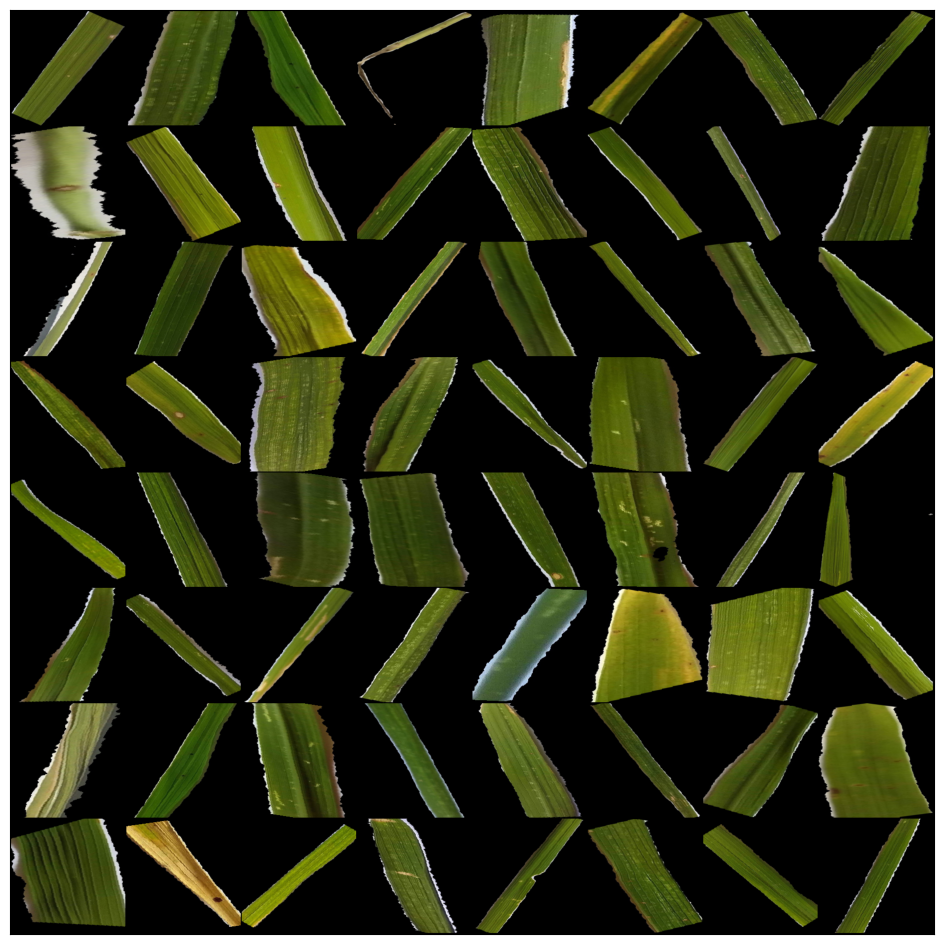

In [ ]:
show_batch(train_dataloader)

# Model Selection & Hyperparameter Tuning

Below are some of the models I tried for the training. Some of them are more complicated than the simple CNN model chose for this task. But most of them couldn't deliver better reuslts than the simple CNN.

In [ ]:
# def conv_block(in_channels, out_channels, pool=False):
#   layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
#           nn.BatchNorm2d(out_channels), 
#           nn.ReLU(inplace=True)]
#   if pool: layers.append(nn.MaxPool2d(2))
#   return nn.Sequential(*layers)

# class ResNet9(nn.Module):
#   def __init__(self, in_channels, num_classes):
#     super().__init__()
        
#     self.conv1 = conv_block(in_channels, 64)
#     self.conv2 = conv_block(64, 128, pool=True)
#     self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
#     self.conv3 = conv_block(128, 256, pool=True)
#     self.conv4 = conv_block(256, 512, pool=True)
#     self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
#     self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
#                     nn.Flatten(), 
#                     nn.Dropout(0.2),
#                     nn.Linear(512, num_classes))
        
#   def forward(self, xb):
#     out = self.conv1(xb)
#     out = self.conv2(out)
#     out = self.res1(out) + out
#     out = self.conv3(out)
#     out = self.conv4(out)
#     out = self.res2(out) + out
#     out = self.classifier(out)
#     return out

# model = ResNet9(3, 4)

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.nn import TransformerEncoder, TransformerEncoderLayer

# class CNNModel(nn.Module):
#     def __init__(self, num_classes=4):
#         super(CustomModel, self).__init__()
        
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
#         self.flatten = nn.Flatten()

#         self.fc1 = nn.Linear(128 * 56 * 56, 256)
#         self.fc2 = nn.Linear(256, num_classes)

#     def forward(self, x):
#         x = self.pool1(F.relu(self.conv1(x)))
#         x = self.pool2(F.relu(self.conv2(x)))
#         x = F.relu(self.conv3(x))
        
#         x = self.flatten(x)
#         x = x.view(x.size(0), 128, -1).permute(0, 2, 1)
#         x = x.permute(0, 2, 1).contiguous().view(x.size(0), -1)
        
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# model = CNNModel()

In [ ]:
# class VGG(nn.Module):
#     def __init__(self, num_classes=4):
#         super(CustomVGG, self).__init__()

#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.25),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.25),

#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.25),
#         )

#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

#         self.classifier = nn.Sequential(
#             nn.Linear(256 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

# model = VGG()

In [ ]:
# The model was built following the steps of the tutorial below
# https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64* 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [ ]:
# Get the model details
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          18,496
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Linear-7                  [-1, 512]      25,690,624
           Dropout-8                  [-1, 512]               0
            Linear-9                    [-1, 4]           2,052
Total params: 25,716,260
Trainable params: 25,716,260
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 13.41
Params size (MB): 98.10
Estimated Total Size (MB): 112.08
---------------------------------

In [ ]:
# Visualise the model architecture
# https://appsilon.com/visualize-pytorch-neural-networks/
X, _ = next(iter(train_dataloader))
y = model(X)

graph = make_dot(y.mean(), params=dict(model.named_parameters()))
graph.format = 'png'
graph.render(DIR_MODEL+'computation_graph', cleanup=True)

'drive/MyDrive/COMP9417/computation_graph.png'

# Training Process

In [ ]:
from torch.optim import Adam
from torch.optim import RMSprop

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
  model.train()
  train_loss = 0
  train_predictions, train_targets = [], []
  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
        
    train_loss += loss.item()
    _, preds = torch.max(outputs, 1)
    train_predictions.extend(preds.cpu().numpy())
    train_targets.extend(labels.cpu().numpy())

  model.eval()
  with torch.no_grad():
    predictions, targets = [], []
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    # Calculate metrics
    train_acc = accuracy_score(train_targets, train_predictions)
    train_loss /= len(train_dataloader)
    val_acc = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}")

  if input_data == 'preprocessed':
    torch.save(model.state_dict(), DIR_MODEL + 'model_preprocessed_CNN.pth')
  else:
    torch.save(model.state_dict(), DIR_MODEL + 'model_original_CNN.pth')


Epoch 1/60
Train Loss: 1.5243, Train Accuracy: 0.4214
Validation Accuracy: 0.4239, Precision: 0.1797, Recall: 0.4239, F1 score: 0.2524


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/60
Train Loss: 1.2508, Train Accuracy: 0.4549
Validation Accuracy: 0.4657, Precision: 0.3031, Recall: 0.4657, F1 score: 0.3431


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/60
Train Loss: 1.1681, Train Accuracy: 0.5093
Validation Accuracy: 0.5134, Precision: 0.4332, Recall: 0.5134, F1 score: 0.4309


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/60
Train Loss: 1.1508, Train Accuracy: 0.5175
Validation Accuracy: 0.5134, Precision: 0.4050, Recall: 0.5134, F1 score: 0.4415


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/60
Train Loss: 1.1391, Train Accuracy: 0.5216
Validation Accuracy: 0.4955, Precision: 0.4126, Recall: 0.4955, F1 score: 0.4275


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/60
Train Loss: 1.1029, Train Accuracy: 0.5376
Validation Accuracy: 0.5254, Precision: 0.4379, Recall: 0.5254, F1 score: 0.4412


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/60
Train Loss: 1.0954, Train Accuracy: 0.5428
Validation Accuracy: 0.4925, Precision: 0.4258, Recall: 0.4925, F1 score: 0.4067


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/60
Train Loss: 1.0733, Train Accuracy: 0.5540
Validation Accuracy: 0.5075, Precision: 0.4134, Recall: 0.5075, F1 score: 0.4400


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/60
Train Loss: 1.0681, Train Accuracy: 0.5537
Validation Accuracy: 0.5373, Precision: 0.4322, Recall: 0.5373, F1 score: 0.4710


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/60
Train Loss: 1.0651, Train Accuracy: 0.5466
Validation Accuracy: 0.4687, Precision: 0.4350, Recall: 0.4687, F1 score: 0.3818
Epoch 11/60
Train Loss: 1.0763, Train Accuracy: 0.5447
Validation Accuracy: 0.5284, Precision: 0.4503, Recall: 0.5284, F1 score: 0.4483


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/60
Train Loss: 1.0391, Train Accuracy: 0.5678
Validation Accuracy: 0.4746, Precision: 0.4056, Recall: 0.4746, F1 score: 0.4079
Epoch 13/60
Train Loss: 1.0353, Train Accuracy: 0.5686
Validation Accuracy: 0.5493, Precision: 0.4505, Recall: 0.5493, F1 score: 0.4798


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/60
Train Loss: 1.0082, Train Accuracy: 0.5782
Validation Accuracy: 0.5134, Precision: 0.4930, Recall: 0.5134, F1 score: 0.4719
Epoch 15/60
Train Loss: 0.9917, Train Accuracy: 0.5868
Validation Accuracy: 0.5433, Precision: 0.4878, Recall: 0.5433, F1 score: 0.4839
Epoch 16/60
Train Loss: 0.9850, Train Accuracy: 0.6006
Validation Accuracy: 0.5403, Precision: 0.4398, Recall: 0.5403, F1 score: 0.4722


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/60
Train Loss: 0.9557, Train Accuracy: 0.6047
Validation Accuracy: 0.5582, Precision: 0.6128, Recall: 0.5582, F1 score: 0.5197
Epoch 18/60
Train Loss: 0.9310, Train Accuracy: 0.6151
Validation Accuracy: 0.5433, Precision: 0.6339, Recall: 0.5433, F1 score: 0.4797
Epoch 19/60
Train Loss: 0.8969, Train Accuracy: 0.6308
Validation Accuracy: 0.5642, Precision: 0.5909, Recall: 0.5642, F1 score: 0.5198
Epoch 20/60
Train Loss: 0.8680, Train Accuracy: 0.6613
Validation Accuracy: 0.5284, Precision: 0.5512, Recall: 0.5284, F1 score: 0.5090
Epoch 21/60
Train Loss: 0.8335, Train Accuracy: 0.6744
Validation Accuracy: 0.5851, Precision: 0.6106, Recall: 0.5851, F1 score: 0.5487
Epoch 22/60
Train Loss: 0.8054, Train Accuracy: 0.6911
Validation Accuracy: 0.5731, Precision: 0.5700, Recall: 0.5731, F1 score: 0.5487
Epoch 23/60
Train Loss: 0.7632, Train Accuracy: 0.7049
Validation Accuracy: 0.6000, Precision: 0.6052, Recall: 0.6000, F1 score: 0.5740
Epoch 24/60
Train Loss: 0.7241, Train Accuracy: 

# Testing Process

In [ ]:
# Load the saved model
if input_data == 'original':
  model.load_state_dict(torch.load(DIR_MODEL + 'model_original_CNN.pth'))
else:
  model.load_state_dict(torch.load(DIR_MODEL + 'model_preprocessed_CNN.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluate on the test set
with torch.no_grad():
  test_predictions, test_targets = [], []
  for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_predictions.extend(preds.cpu().numpy())
    test_targets.extend(labels.cpu().numpy())

  # Calculate metrics
  test_acc = accuracy_score(test_targets, test_predictions)
  test_precision = precision_score(test_targets, test_predictions, average='weighted')
  test_recall = recall_score(test_targets, test_predictions, average='weighted')
  test_f1 = f1_score(test_targets, test_predictions, average='weighted')
  test_cm = confusion_matrix(test_targets, test_predictions)

  print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 score: {test_f1:.4f}")
  print(f"Confusion Matrix:\n{test_cm}")

Test Accuracy: 0.6369, Precision: 0.6338, Recall: 0.6369, F1 score: 0.6343
Confusion Matrix:
[[ 29  12   2   8]
 [  6 109  20  11]
 [  0  23  20  12]
 [  8  10  10  56]]
